In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from confutils import get_initial_structure, get_dihedral_info, set_dihedrals_and_relax, relax_structure
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import PairwiseKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
from modAL.disagreement import max_std_sampling
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error
import warnings
warnings.simplefilter('ignore')

## Problem 1: Active Learning for $n$-butane

#### Setup: Loading Conformer Data

In [7]:
#Load Butane Data from Background Notebook Search
butane = pd.read_csv(r'C:\Users\ascoh\Desktop\UChicago\Academics\2020-21\Q2 2021\AI for MatSci\Optimal Experiment Design\Data\n-butane.csv')

In [8]:
#Show that this is in fact butane
atoms, g = get_initial_structure('CCCC')
print(atoms)

Atoms(symbols='C4H10', pbc=False)


In [9]:
%%time
#Print the initial energy
start_energy = relax_structure(atoms)
print(f'Energy of the initial geometry: {start_energy:.2f} Ha')

Energy of the initial geometry: -4310.58 Ha
Wall time: 3.01 s


In [10]:
#uses the bonding graph to pick the other two atoms to form the dihedral for a bond
#(ideally from the backbone atoms) and then identify the atoms that must be rotated together.
dh1 = get_dihedral_info(g, [1, 2], backbone_atoms=[0, 1, 2, 3])
dh1

DihedralInfo(chain=[0, 1, 2, 3], group={2, 3, 9, 10, 11, 12, 13})

In [360]:
print(f'Starting dihedral: {atoms.get_dihedral(*dh1.chain): .2f}')

Starting dihedral:  180.00


In [361]:
#Scan over many dihedral angles using the set_dihedrals_and_relax.
#This function rotates the target dihedral(s), fixes the angle and the relaxes
#all other degrees of freedom of the molecule

phis = np.linspace(0, 360, 33)
energies = np.array([
    set_dihedrals_and_relax(atoms, [(p, dh1)]) - start_energy
    for p in tqdm(phis)
])

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:56<00:00,  1.70s/it]


Text(0, 0.5, '$\\Delta E$')

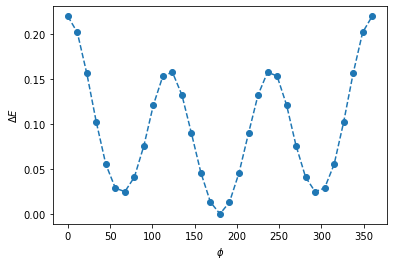

In [362]:
fig, ax = plt.subplots()

ax.plot(phis, energies, '--o')

ax.set_xlabel('$\\phi$')
ax.set_ylabel('$\Delta E$')

Generate a subset of the data where we fix phi_2 to be constant so that the global energy is minimized (as in Example 1).

In [363]:
np.argmin(butane['energy'])

544

In [11]:
butane_1d = butane.copy()
#Remove phi2 data
del butane_1d['phi2']
#Restrict data set only to phi1 data 0-360 that contains the global minimum
butane_1d = butane_1d[528:561]

## Part A: Learning a Potential Enery Surface

Dihedral angles are periodic (e.g., 0 and 360 are the same) and we can create a kernel that reflects that by using a periodic kernel:

$K(x, y) = \sum_i \exp(-2 \frac{\sin^2(\pi (x_i - y_i)^2/p)}{l^2})$

We can use this custom kernel with Scikit-Learn's GuassianProcessRegressor by writing it a function to use with the PairwiseKernel class, which accepts custom kernels:

In [365]:
def elementwise_expsine_kernel(x, y, gamma=10, p=360):
    """Compute the expoonential sine kernel
    
    Args:
        x, y: Coordinates to be compared
        gamma: Length scale of the kernel
        p: Periodicity of the kernel
    Returns:
        Kernel metric
    """
    
    # Compute the distances between the two points
    dists = np.subtract(x, y)
    
    # Compute the sine with a periodicity of p
    sine_dists = np.sin(np.pi * dists / p)
    
    # Return exponential of the squared kernel
    return np.sum(np.exp(-2 * np.power(sine_dists, 2) / gamma ** 2), axis=-1)

gpr = GaussianProcessRegressor(
    kernel=PairwiseKernel(metric=elementwise_expsine_kernel),
    # Starts using different guesses for parameters to achieve better fitting
    n_restarts_optimizer=4  
)

Take a **random subset of 2 points** from *butane_1d*. Use those points to **fit a model with the Sine kernel** introduced above and an **RBF kernel** (find how in scikit-learn documentation). Note that you should add **n_restarts_optimizer=16** to the arguments for the RBF model to be able to fit our data well.

In [779]:
X=np.array(butane_1d['phi1'])
y=np.array(butane_1d['energy'])

X = np.expand_dims(X, 1)

#Create the random subset of two ponits in X_train
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2)

In [780]:
#Rename gpr regressor to model
model = gpr
#Fit the model for use in prediction
model.fit(X_train, y_train)
y1_mean, y1_std = model.predict(X, return_std = True) #model.predict() returns a mean as the prediciton

In [781]:
#Repeat above cell for RBF
model_RBF = gpr_RBF = GaussianProcessRegressor(kernel = RBF(length_scale=1.0), n_restarts_optimizer=16)

model_RBF.fit(X_train, y_train)
y2_mean, y2_std = model_RBF.predict(X, return_std = True)

### Q1-A

**Plot the mean and standard deviations of the predictions as a function of phi_1** (You may want to run the fitting multiple times to avoid basing your conclusion on haphazard, while you only need to show two plots in the notebook, one for each kernel, respectively).

Text(0.5, 0, 'phi_1')

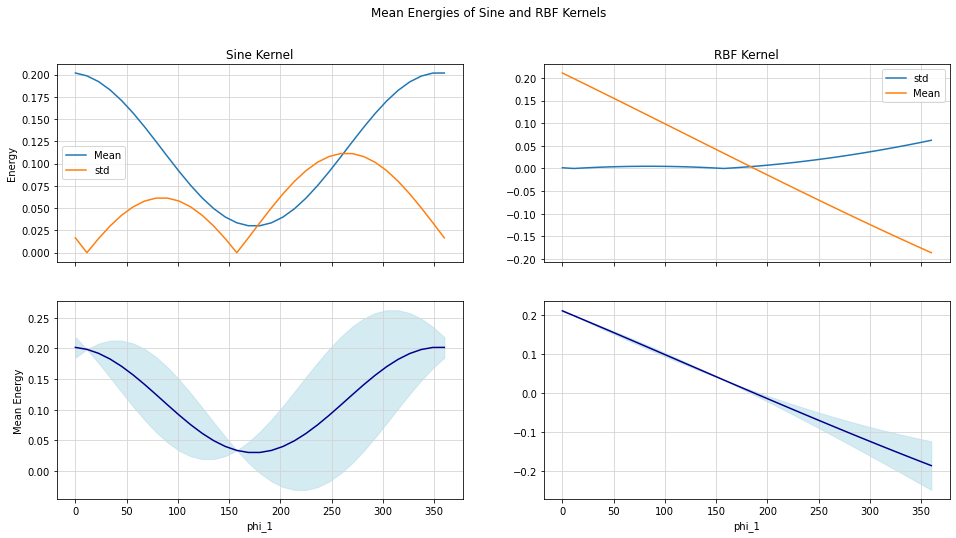

In [786]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(16,8))
fig

ax=axs[0,0]
ax.get_xlim()
ax.plot(X,y1_mean, label = 'Mean')
ax.plot(X,y1_std, label = 'std')
ax.set_title('Sine Kernel')
ax.set_ylabel('Energy')
ax.grid(color='lightgrey')
ax.legend()



ax=axs[0,1]
ax.plot(X,y2_std, label = 'std')
ax.plot(X, y2_mean, label = 'Mean')
ax.set_title('RBF Kernel')
ax.legend()
ax.grid(color='lightgrey')

fig.suptitle('Mean Energies of Sine and RBF Kernels')

ax=axs[1,0]
ax.plot(X,y1_mean, label = 'Mean', color='darkblue')
ax.fill_between(butane_1d['phi1'], y1_mean-y1_std, y1_mean+y1_std, alpha=0.5, color='lightblue')
ax.set_ylabel('Mean Energy')
ax.grid(color='lightgrey')
ax.set_xlabel('phi_1')



ax=axs[1,1]
ax.plot(X,y2_mean, label = 'Mean', color='darkblue')
ax.fill_between(butane_1d['phi1'], y2_mean-y2_std, y2_mean+y2_std, alpha=0.5, color='lightblue')
ax.grid(color='lightgrey')
ax.set_xlabel('phi_1')

## Q1-A
Which function is a better approximator of the energy? 

 - The Sine Kernel is a better approximator of the energy. By comparing the two plots we see that the Sine Kernel produces predictions that are more similar to the physical behavior of butane conformer energy. Furthermore, we note that the RBF Kernel predicts negative energy values which should not be allowed under this model of energy.
 - It should also be notted that I did in fact run fitting multiple times before plotting. I performed multiple trials of this and recieved the same conclusion.

Next, go back to the **original 2D dataset with no constraint on phi_2**. Train a series of models with **each of the two kernels**, with randomly-selected subsets of *3, 10, 30, and 100 points* (in all there should be 2 x 4 models). **Measure the error** on the full dataset.

In [634]:
X=np.array(butane['phi1'])
y=np.array(butane['energy'])

X = np.expand_dims(X, 1)

#Create end result lists
SINE_results = []
RBF_results = []

#Training the kernel Models
for i in tqdm((3,10,30,100)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=i)

    model.fit(X_train, y_train)
    y1_pred, y1_std = model.predict(X, return_std = True)
    SINE_results.append({
            'train_size': i,
            'E_pred': y1_pred,
            'E_true': y_test,
            'pred_std': y1_std,
            'mean': np.mean(y1_pred),
            'mae': mean_absolute_error(y, y1_pred)
        })

    model_RBF.fit(X_train, y_train)
    y2_pred, y2_std = model_RBF.predict(X, return_std = True)
    RBF_results.append({
            'train_size': i,
            'E_pred': y2_pred,
            'E_true': y_test,
            'pred_std': y2_std,
            'mean': np.mean(y2_pred),
            'mae': mean_absolute_error(y, y2_pred)
        })
    
#Convert lists to DataFrames
SINE_df = pd.DataFrame(SINE_results)
RBF_df = pd.DataFrame(RBF_results)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:41<00:00, 25.33s/it]


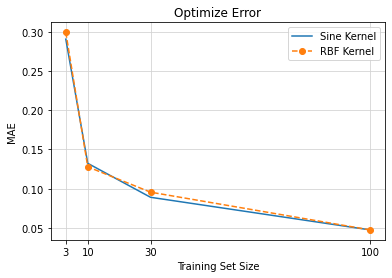

In [635]:
#Plot the MAE of each kernel model by training size
fig, ax = plt.subplots()
fig

ax.plot(SINE_df['train_size'].values,SINE_df['mae'].values, label = 'Sine Kernel')
ax.plot(RBF_df['train_size'].values,RBF_df['mae'].values,'o--', label = 'RBF Kernel')

ax.set_title('Optimizer Error')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('MAE')
plt.xticks((3,10,30,100),(3,10,30,100))
#ax.grid()
ax.legend()
ax.grid(color='lightgrey')

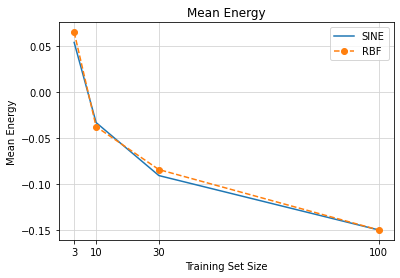

In [700]:
#Plot the Mean Energy of each kernel model by training size
fig, ax = plt.subplots()
fig

ax.plot(SINE_df['train_size'], -SINE_df['mean'], label = 'SINE')
ax.plot(RBF_df['train_size'], -RBF_df['mean'], 'o--', label = 'RBF')
ax.set_title('Mean Energy')
ax.set_xlabel('Training Set Size')
ax.set_ylabel('Mean Energy')
plt.xticks((3,10,30,100),(3,10,30,100))
ax.legend()
ax.grid(color='lightgrey')

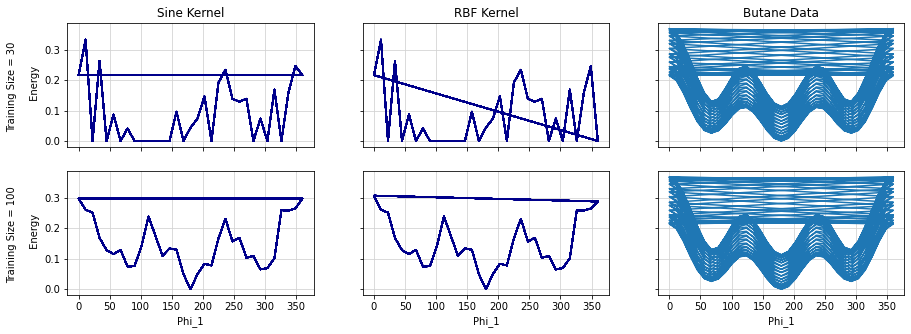

In [663]:
#Comparing the predictions of each kernel model vs. the actual Butane data for the training sizes 30 and 100 points

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,5))
fig

ax=axs[0,0]
ax.get_xlim()
#ax.plot(X, SINE_df['pred_std'][3], label = 'std')
ax.plot(X, SINE_df['E_pred'][2], label = 'pred', color = 'darkblue')
ax.set_title('Sine Kernel')
ax.set_ylabel('Training Size = 30 \n \n Energy')
#ax.set_xlabel('Phi_1')
ax.grid(color='lightgrey')


ax=axs[0,1]
ax.get_xlim()
#ax.plot(X, SINE_df['pred_std'][3], label = 'std')
ax.plot(X, RBF_df['E_pred'][2], label = 'pred', color = 'darkblue')
ax.set_title('RBF Kernel')
#ax.set_xlabel('Phi_1')
ax.grid(color='lightgrey')


ax=axs[0,2]
ax.plot(X,y)
ax.set_title('Butane Data')
ax.grid(color='lightgrey')

ax=axs[1,0]
ax.get_xlim()
ax.plot(X, SINE_df['E_pred'][3], label = 'pred', color = 'darkblue')
ax.set_ylabel('Training Size = 100 \n \n Energy')
ax.set_xlabel('Phi_1')
ax.grid(color='lightgrey')


ax=axs[1,1]
ax.get_xlim()
ax.plot(X, RBF_df['E_pred'][3], label = 'pred', color = 'darkblue')
ax.set_xlabel('Phi_1')
ax.grid(color='lightgrey')


ax=axs[1,2]
ax.plot(X,y)
ax.set_xlabel('Phi_1')
ax.grid(color='lightgrey')

In [701]:
print(SINE_df['mae'])
print(RBF_df['mae'])

0    0.290460
1    0.132330
2    0.089091
3    0.047524
Name: mae, dtype: float64
0    0.299260
1    0.127872
2    0.095601
3    0.047537
Name: mae, dtype: float64


### Q1-A
Plot the error in the Sine kernel model and the RBF kernel model as a function of training set size. Which model performs better? Explain why.

 - As can be seen by the MAE plot and data above, the Sine kernel model performs better, albeit only slightly. This is because the Sine Kernel is designed to model periodic functions. Referring to the original butane energies plotted against phi1, we see that the conformer energy is indeed periodic. The RBF kernel meanwhile relies on Euclidean distance relations to determine two point's similarity. If two point are close they are computed to be similar while if they are far apart they are computed to be disimlar. While this kernel still performs well on the butane data, there is greater potential for error since the data is, in fact, periodic, thus resulting in the appearance of repeated distance relations that could cause the kernel errors as the dataset scales.

## Part B: Bayesian Optimization for Conformer Search

Now that we have a model, our next step is to use Bayesian optimization to guide our search for the conformers. We will use modAL's BayesianOptimizer tool. As highlighted in the example for Bayesian Optimization, you use modAL by first defining an optimizer with an initial training set, GPR model and an acquisition function:

In [744]:
#Initialize EI Optimizer

initial_data = butane.sample(4)
input_cols = ['phi1', 'phi2']
optimizer_EI = BayesianOptimizer(
    estimator=gpr,
    X_training=initial_data[input_cols].values,  # .values removes Panda's indices
    # negative because modAL is designed to maximize a function
    y_training=-initial_data['energy'].values,  
    query_strategy=max_EI
)

Once you have it a step of the process of "pick next point then add to training data" is

In [745]:
chosen_inds, chosen_coords = optimizer_EI.query(butane[input_cols].values)
optimizer_EI.teach(
    butane[input_cols].iloc[chosen_inds].values, 
    -butane['energy'].iloc[chosen_inds].values
)

Run an **active learning search** where you *start with 4 points that were determined randomly* and then *select 16 points* using maximum expected **improvment (max_EI)** and **uncertainty sampling max_std_sampling**.

In [746]:
#Active Learning Seach: Maximum Expected Improvement

seed_data, search_data = train_test_split(butane, train_size=4)

search_X_16 = search_data[input_cols].values
train_EI_X = (seed_data[input_cols].values).tolist()
train_EI_y = seed_data['energy'].tolist()

for step in tqdm(range(16)):
    # Run the query with the AI tool
    chosen_inds, chosen_coords = optimizer_EI.query(search_X_16)
    
    # Remove that value from the search space
    search_X_16 = np.delete(search_X_16, chosen_inds, axis=0)
    
    # Add it to the training set
    train_EI_X.extend(chosen_coords)
    train_EI_y.extend(search_data['energy'][chosen_inds])
    
    # Retrain the ensemble
    optimizer_STD.fit(train_STD_X, train_STD_y)
    
    # Reset the active learning agent
    #optimizer_EI = BayesianOptimizer(
    #estimator=gpr, 
    #query_strategy=max_EI
    #)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:43<00:00,  2.73s/it]


In [747]:
#Initialize Std Optimizer

initial_data = butane.sample(4)
input_cols = ['phi1', 'phi2']
optimizer_STD = BayesianOptimizer(
    estimator=gpr,
    X_training=initial_data[input_cols].values,  # .values removes Panda's indices
    # negative because modAL is designed to maximize a function
    y_training=-initial_data['energy'].values,  
    query_strategy=max_std_sampling
)

chosen_inds, chosen_coords = optimizer_STD.query(butane[input_cols].values)
optimizer_STD.teach(
    butane[input_cols].iloc[chosen_inds].values, 
    -butane['energy'].iloc[chosen_inds].values
)

In [748]:
#Active Learning Seach: Maximum Std Sampling

seed_data, search_data = train_test_split(butane, train_size=4)

search_X_16 = search_data[input_cols].values
train_STD_X = (seed_data[input_cols].values).tolist()
train_STD_y = seed_data['energy'].tolist()

for step in tqdm(range(16)):
    # Run the query with the AI tool
    chosen_inds, chosen_coords = optimizer_STD.query(search_X_16)
    
    # Remove that value from the search space
    search_X_16 = np.delete(search_X_16, chosen_inds, axis=0)
    
    # Add it to the training set
    train_STD_X.extend(chosen_coords)
    train_STD_y.extend(search_data['energy'][chosen_inds])
    
    # Retrain the ensemble
    optimizer_STD.fit(train_STD_X, train_STD_y)
    
    # Reset the active learning agent
    #optimizer_STD = BayesianOptimizer(
    #estimator=gpr,  
    #query_strategy=max_std_sampling
    #)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:30<00:00,  1.92s/it]


Plot the lowest-energy conformer as a function of step for each strategy.

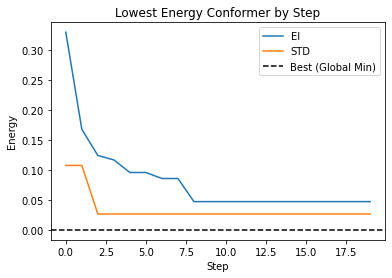

In [749]:
fig, ax = plt.subplots()

ax.plot(np.minimum.accumulate(train_EI_y), label='EI')
ax.plot(np.minimum.accumulate(train_STD_y), label='STD')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [search_data['energy'].min()]*2, 'k--', label='Best (Global Min)')


ax.set_ylabel('Energy')
ax.set_xlabel('Step')
ax.set_title('Lowest Energy Conformer by Step')
ax.legend()

In [750]:
### ISSUES - the two query strategies give same predictions###

X= np.array(butane[input_cols].values)
y= np.array(butane['energy'].values)

#X = X.reshape(-1, 1)

y_EI_pred = optimizer_EI.predict(X)

y_STD_pred = optimizer_STD.predict(X)

mae = []
mae.append({'EI MAE': mean_absolute_error(y, y_EI_pred),
            'STD MAE': mean_absolute_error(y, y_STD_pred),        })  
mae_df = pd.DataFrame(mae)

mae_df

,EI MAE,STD MAE
0,0.093821,0.093821


### Q1-B

1. **Which query strategy finds the lowest-energy conformer?**

    - The Max STD Sampling finds the lowest-energy conformer as seen in the plot above (orange line).
    

2. **Measure the prediction performance of the model on the full butane dataset. Which query strategy creates the best model?**

    - Accoding the my code the performance of their respective predictions is identical. This can be seen in the comparison of their MAE's above.
    

3. **Explain the difference between the two query strategies and why their performances are different.**

    - The two query strategies are functions that use different methods to evaluate whether a point within the optimizer search space indeed optimizes the model provided.
    
        -The Max Expected Improvement strategy is an acquisition function that evaluates all points in refernce to the regressor's mean value, attempting to maximize the resulting productive change following the calculation of a point. This method also involves a parameter ξ that allows direct control over the ratio of exploration vs exploitation of the function.
        
        -The Maximum STD Sampling function is a measure of the disagreement between an ensemble of regressors. The function does this by using the standard devations of the regressors to calculate the disagreement. Using this prediction of uncertainty the query strategy can choose a new point to optimize this disagreement.

## Problem 2: Optimizing cysteine

Cysteine has 5 adjustable bondes, which makes it a much more difficult optimization problem. The issue with having many bonds is that sampling the conformer space becomes difficult. For butane, we used 33 samples per axis which leads to $33^2 = 1089$ points to evaluate at each step, which is very easy to evaluate with a GPR. The same sampling density for cysteine would be $33^5 = 39135393$, which would be too time consuming. Rather, we can use a global optimizer to suggest which points to sample.

In [572]:
with open('data/cysteine-atoms.pkl', 'rb') as fp:
    cysteine = pkl.load(fp)

# Definitions for the dihedral angles of cysteine
with open('data/dihedrals.pkl', 'rb') as fp:
    dihedrals = pkl.load(fp)

In [573]:
from confutils import set_dihedrals_and_relax

def evaluate_energy(angles):
    """Compute the energy of a cysteine molecule given dihedral angles
    
    Args:
        angles: List of dihedral angles
    Returns:
        energy of the structure
    """
    return set_dihedrals_and_relax(
        cysteine,
        zip(angles, dihedrals)
    )

In [574]:
def get_search_space(optimizer: BayesianOptimizer, n_samples: int = 32):
    """Generate many samples by attempting to find the minima using a multi-start local optimizer
    
    Args: 
        optimizer: Optimizer being used to perform Bayesian optimization
        n_samples: Number of initial starts of the optimizer to use. 
            Will return all points sampled by the optimizer
    Returns:
        List of points to be considered
    """
    
    # Generate random starting points
    init_points = np.random.uniform(0, 360, size=(n_samples, 5))
    
    # Use local optimization to find the minima near these
    points_sampled = []  # Will hold all samples tested by the optimizer
    for init_point in init_points:
        minimize(
            # Define the function to be optimized
            #  The optimizer requires a 2D input and returns the negative energy
            #  We make our inputs 2D and compute the negative energy with a lambda function
            lambda x: -optimizer.predict([x]),  # Model predicts the negative energy and requires a 2D array,
            init_point,  # Initial guess
            method='nelder-mead',  # A derivative-free optimizer
             # Stores the points sampled by the optimizer at each step in "points_sampled"
            callback=points_sampled.append
        )
    
    # Combine the results from the optimizer with the initial points sampled
    all_points = np.vstack([
        init_points,
        *points_sampled
    ])
    return all_points

Generate a set of **4 initial points where the values for each of the 5 dihedrals are chosen randomly** from between 0 and 360 degrees.

**Compute their energy** and use them to create a **Bayesian optimizer with the EI query strategy**.

In [764]:
#Generate the 4 random points - 5 angles each
init_points = np.zeros((4,5))
for j in range(4):
    init_points[j] = np.random.uniform(0, 360, size=5)

In [765]:
#Calculate the energy of the 4 initial points - 4 total energies
#Compile Angles and Energies into Init(list) -- convert to dataframe

init_energy = np.zeros((4,1)) #used to avoid iterating over a float
Init = []
for j in range(len(init_points)):
    init_energy[j] = evaluate_energy(init_points[j])
 
    Init.append({'Angles': init_points[j],
                'Calculated Energy': init_energy[j]})
    
Init = pd.DataFrame(Init)

In [766]:
#initialize the Optimizer using Max EI
initial_data = init_points
optimizer_cys = BayesianOptimizer(
    estimator=gpr,
    X_training=init_points,
    # negative because modAL is designed to maximize a function
    y_training=-init_energy,  
    query_strategy=max_std_sampling
)

Write a loop that follows the following procedure:

1. Use the get_search_space function to create a series of points to be sampled
2. Select the best points to query with the optimizer
3. Evaluate the energy of the best points using evaluate_energy so that the results are more accurate, with reasonable sacrifice in efficiency
4. Add the best points and new energies to the training set of the optimizer

Run the loop **32 times** to try to find the lowest energy conformer. 

In [767]:
train_cys_X = init_points.tolist()
train_cys_y = init_energy.tolist()

cys_results= []

for step in tqdm(range(32)):
    
    #Create Search Space
    cys_search_space = get_search_space(optimizer_cys)
    
    # Run the query with the AI tool
    chosen_inds, chosen_coords = optimizer_cys.query(cys_search_space)
    
    #Compute the Energy for the query
    chosen_energy = evaluate_energy(chosen_coords.reshape(5))
    
    # Add it to the training set
    train_cys_X.append(chosen_coords)
    train_cys_y.append([chosen_energy])
    
    # Retrain the ensemble
    optimizer_cys.fit(np.vstack(train_cys_X), np.squeeze(train_cys_y))
    
    # Reset the active learning agent
    #optimizer_cys = BayesianOptimizer(
    #estimator=gpr,
    #X_training=init_points,
    # negative because modAL is designed to maximize a function
    #y_training=-init_energy,  
    #query_strategy=max_EI
    #)
    
    cys_results.append({
                        'Step': step,
                        'Energy': chosen_energy})
    
cys_results_df = pd.DataFrame(cys_results)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [32:24<00:00, 60.78s/it]


**Plot the energy of each sampled point as a function of step**.

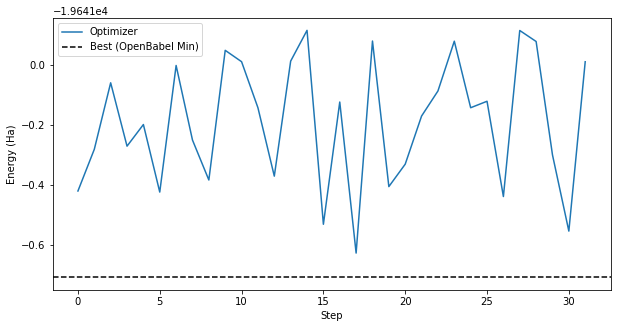

In [775]:
fig, ax = plt.subplots(figsize=((10,5)))

ax.plot(cys_results_df['Step'], cys_results_df['Energy'], label = 'Optimizer')

OpenBableMin = -19641.7084 
ax.set_xlim(ax.get_xlim())
OpenBableMin_np = np.array(len(ax.get_xlim()) * [-19641.7084] )
ax.plot(ax.get_xlim(),  OpenBableMin_np, 'k--', label='Best (OpenBabel Min)')


ax.set_ylabel('Energy (Ha)')
ax.set_xlabel('Step')
ax.legend()

In [777]:
OpenBableMin - max(cys_results_df['Energy'])

-0.8238089621481777

In [776]:
OpenBableMin - min(cys_results_df['Energy'])

-0.0812491226097336

**Describe the energies of the conformers compared to that of the one produced by OpenBabel** ($E = -19641.7084$ Ha):

    - The energies of the conformers on average approach the OpenBabel energy, coming within 0.0812491226097336 Ha of the actual value. It is encouraging that all of the reported energies are within, approximately, a single unit of the OpenBabel Energy. However, given the inconsistency of the data between steps it is difficult to make a firm conclusion regarding the performance of the model.
    - It should also be noted that model performance did change upon each run of the entire training loop so it may be possible to get superior performance through shear probability.